 # Test the tuned Model

 In the last notebook, we have seen the steps to fine tune the AlexNet model using the MNIST dataset.
 In this notebook, we will load the tuned model shared by NICD and then will test it with the MNIST data.

 In the package import section below, we have used two new import statements which are `torch.nn` and `matplotlib.pyplot`.
 In which, `torch.nn provides the basic building blocks for the construction of the neural network and for replacing model layers, and
 `matplotlib.pyplot` is a collection of functions used for plotting, that make `matplotlib` work like MATLAB through which we can create figures.

In [55]:
import torch
from torchvision import models, transforms, datasets
import torch.nn as nn
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
import torch.utils.data as data_utils
import pickle
import numpy as np
from sklearn.metrics import (PrecisionRecallDisplay, auc,  average_precision_score, precision_recall_curve, roc_curve)

 The `transforms` module used in the below snippet helps us in transforming the greyscaled MNIST data into a tensor.


In [56]:
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.ToTensor(),
 # MNIST is greyscale so we stack the image to create 3 channels
 transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
 transforms.Normalize(
 mean=[0.485, 0.456, 0.406],
 std=[0.229, 0.224, 0.225]),
 ])


 Torchvision provides many built-in datasets in the `torchvision.datasets` module.
 Here, we have downloaded the MNIST dataset and stored it in the directory named as `data`.
 The dataloader used here combines a dataset and a sampler, and provides an iterable over the given dataset.

In [57]:
mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
MNIST_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=1, shuffle=True)


 In the following snippet, we have created an AlexNet model without using the pre-trained keyword. This provides the default AlexNet model with randomly initialised parameters.
 If we inspect the model, we can see the model architecture with `out_feature=1000` in its last layer.

In [58]:
model = models.alexnet()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

 # Redefining the layers
 The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.
 So, we need to replace the last layer with 10 neurons.
 `nn.Linear(n,m)` is a module that creates single layer feed-forward network with n inputs and m outputs, through which we can update the output of our last layer.

In [59]:
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs,10)


 If we check the model architecture, we can see the `out_features` of the last layer was updated to 10.

In [60]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 


 Now, we have our expected model architecture for MNIST data prediction.
 However, as this model has not been trained it is not yet capable of making sensible predictions. Instead of training the model with the MNIST dataset, we can directly load a fine-tuned model, and in this case we used the fine-tuned AlexNet model shared by NICD.
 Training a model in a CPU machine will take a long time.
 So with the help of NICD, we fine-tuned our pre-trained alexnet model with the MNIST dataset using NICD's GPU machine which took approximately 40 to 50 minutes for 50 epochs.

 To load this fine-tuned model, we need to place the model file (mnist_head_alexnet.pth) in the same directory of our source code.
 Then, using `torch.load()` we can deserialize python's object files to memory.
 Finally, by using `load_state_dict`, we can load a model’s parameter dictionary using the deserialized `state_dict`.

 In PyTorch, the learnable parameters (i.e. weights and biases) of an `torch.nn.Module` model are contained in the model’s parameters (accessed with `model.parameters()`).
 A `state_dict` is simply a Python dictionary object that maps each layer to its parameter tensor.
 Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers have entries in the model’s `state_dict`.

 NOTE: The `map_location` argument is used here because the model was trained on a computer with a GPU avaliable. This means that the `state_dict` contains references to the GPU which will cause an error on a device where only a CPU is avaliable. This argument allows us to specify the device on which all tensors should be created.

In [61]:
model.load_state_dict(torch.load('mnist_head_alexnet.pth',map_location=torch.device('cpu')))
model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

 Since, we are going to test the model directly we are using eval mode in the above snippet.
 Next, we need to pass our MNIST data into our model and predict the output.
 So, using the following code snippet we iterated and picked a single data point from our dataset.

In [62]:
sample_image = iter(MNIST_test_loader).next()[0]
sample_image

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

 Our sample image is in tensor format.
 To visualise the selected data, we used matplotlib.pyplot to create the figure of the image as shown in the snippet below.

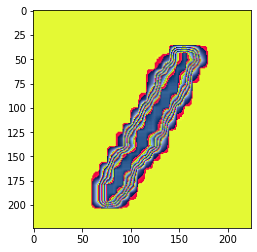

In [63]:
pil_iamge = transforms.ToPILImage()(sample_image.squeeze(0))
plt.imshow(pil_iamge, cmap='gray')


 Finally, we just pass our sample test data into our model which predits the probablities of each tensor [0-9].

In [64]:
pred =model(sample_image)
pred

tensor([[-7.4302,  9.5752, -3.5062, -6.6354,  0.3349, -3.6527, -3.3395,  1.6605,
         -1.8022, -6.2302]], grad_fn=<AddmmBackward0>)

In [65]:
torch.argmax(pred)


tensor(1)

 Then, by using `torch.argmax`, a single element tensor, with the highest probability, is returned and that is our expected output.

**Performance:**
Choosing the right metric is crucial while evaluating machine learning (ML) models.
Also looking at a single metric may not give the whole picture of the problem we are solving, and we may want to use a subset of the metrics discussed in this notebook to have a concrete evaluation of our models.
 
To calculate the performance of our model, let's grab the 100 random data.

In [66]:
sample_idx = torch.arange(100)
test_100 = data_utils.Subset(mnist_test_dataset, sample_idx)


MNIST_test_loader = torch.utils.data.DataLoader(test_100, batch_size=1, shuffle=True)

Then, pass our test data into our model and collect its predictions and tags. These are the key elements in evaluating our model's performance.

In [67]:
predictionList= []
tags =[]

for image, label in MNIST_test_loader:
    predictionList.append(torch.argmax(model(image)))
    tags.append(label)

predictions = torch.stack(predictionList)
tags = torch.cat(tags)

There are various ways to evaluate a classification model and some of the most popular ones are covered in this notebook in the following parts.
 
**Confusion Matrix:**
 
Confusion Matrix is a tabular visualization of the model predictions versus the original labels.
Each row of the confusion matrix represents the instances in a predicted class and each column represents the instances in an actual class.
 
In the following example we are building a multi-class classification (more than two potential labels, as opposed to binary classification) to classify digits from 0 to 9.
We took a test set of 100 MNIST images. Out of these 100 images the model has predicted 98 of them correctly and has misclassified 2 of them.
 
When evaluating the performance of Machine Learning models we often take into account the following values:\
FN: The False-negative value for a class will be the sum of values of corresponding rows except for the TP value.
FP: The False-positive value for a class will be the sum of values of the corresponding column except for the TP value.
TN: The True Negative value for a class will be the sum of values of all columns and rows except the values of that class that we are calculating the values for.
TP: The True positive value is where the actual value and predicted value are the same.

In the multi-class classification problem, we won’t get TP, TN, FP, and FN values directly as in the binary classification problem. We have to calculate these values for each class using the confusion matrix, as described in the following example.


In [68]:
confMatrix = metrics.confusion_matrix(tags, predictions)
confMatrix

array([[ 8,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  8,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  6,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 15,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11]], dtype=int64)

Let us calculate the TP, TN, FP, and FN values for class 3 using the above confusion matrix.
TP: 10 (Class 3)images were identified as True positive.
FN: 1 (Class 5)
FP: 0
TN: 8+14+8+14+6+1+10+15+2+11 = 89
Similarly, we can calculate TP, TN, FP, and FN for the rest of the classes.

Using `matplotlib` function we can visualize the Confusion matrix for better understanding as shown below.

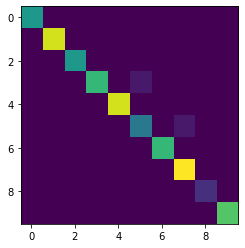

In [69]:
plt.imshow(confMatrix)

**Classification Accuracy:**
 
Classification accuracy is defined as the number of correct predictions divided by the total number of predictions, multiplied by 100.
So in the above example, out of 100 samples, 98 are predicted correctly, resulting in a classification accuracy of 98%.


In [70]:
metrics.accuracy_score(tags, predictions)

0.98

**Precision:**
 
There are many cases in which classification accuracy is not a good indicator of model performance.
One of these scenarios is when our class distribution is imbalanced (one class is more frequent than others).
In this case, even if we predict all samples as the most frequent class we would get a high accuracy rate,
but our model is actually not learning anything, and is just predicting everything as the top class.
 
Therefore, we need to look at class-specific performance metrics too. Precision is one of such metrics, which is defined as:\
`Precision = True_Positive / (True_Positive + False_Positive)`

In [71]:
metrics.precision_score(tags, predictions, average= 'micro')

0.98

As we can see from the above output, the model has much higher precision in predicting Handwritten digits.

**Recall:**

The Recall is another important metric, which refers to the percentage of total relevant results correctly classified by our algorithm.
More formally: `Recall = True_Positive / (True_Positive + False_Negative)`.

In our case, we got a good recall score of 98%.

In [72]:
metrics.recall_score(tags,predictions, average='micro')

0.98

**F1 Score:**

Depending on application, we may give higher priority to recall or precision. 
But there are many applications in which both recall and precision are important. 
One popular metric which combines precision and recall is called F1-score. It is the harmonic mean of precision and recall. 

`F1-score= 2 * Precision * Recall / (Precision + Recall)`


In [73]:
metrics.f1_score(tags, predictions, average='micro')

0.98

We got a good F1-score of 98%. 
There is always a trade-off between precision and recall of a model. If we want to make the precision too high, we may end up seeing a drop in the recall rate, and vice versa.


All the above metrics were performed with the help of `sklearn.metrics`.
This module implements several loss, score, and utility functions to measure classification performance.

# Visualizing the training history of our model:
 
During the training phase of our model (Note_2_FineTuneModel), we recorded the accuracy of each epoch.
Now let's retrieve the accuracy history from the model and visualize it.
 
Firstly, we open the model in read-only mode and then store it in a variable called history. This history will now hold the accuracy of all 50 epochs.

In [74]:
with open('mnist_head_alexnet.pkl', 'rb') as f:
    history = pickle.load(f)

history

[tensor(0.9436, dtype=torch.float64),
 tensor(0.9472, dtype=torch.float64),
 tensor(0.9566, dtype=torch.float64),
 tensor(0.9593, dtype=torch.float64),
 tensor(0.9612, dtype=torch.float64),
 tensor(0.9584, dtype=torch.float64),
 tensor(0.9559, dtype=torch.float64),
 tensor(0.9592, dtype=torch.float64),
 tensor(0.9553, dtype=torch.float64),
 tensor(0.9610, dtype=torch.float64),
 tensor(0.9564, dtype=torch.float64),
 tensor(0.9601, dtype=torch.float64),
 tensor(0.9590, dtype=torch.float64),
 tensor(0.9601, dtype=torch.float64),
 tensor(0.9606, dtype=torch.float64),
 tensor(0.9611, dtype=torch.float64),
 tensor(0.9626, dtype=torch.float64),
 tensor(0.9648, dtype=torch.float64),
 tensor(0.9606, dtype=torch.float64),
 tensor(0.9548, dtype=torch.float64),
 tensor(0.9617, dtype=torch.float64),
 tensor(0.9547, dtype=torch.float64),
 tensor(0.9634, dtype=torch.float64),
 tensor(0.9634, dtype=torch.float64),
 tensor(0.9626, dtype=torch.float64),
 tensor(0.9633, dtype=torch.float64),
 tensor(0.96

Now, using `matplotlib` we can visualize the accuracy of each epoch.

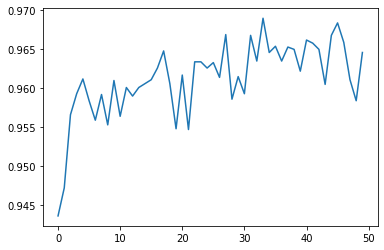

In [75]:
plt.plot(history)

The following color array defines some colours that we will later use in our graphs to differentiate each line in it by colour coding.

In [76]:
# https://colorbrewer2.org/
COLORS = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']


From our MNIST dataset, we are creating a subset by selecting first 1000 data for our calculation.
This is just as an example for our understanding. In real-time, we will be performing the following operations against our entire dataset.
 
In the following code, we have created a list called probabilities to store our test images and a `NumPy` array for their labels.

In [77]:
mnist_test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
subset = torch.utils.data.Subset(mnist_test_dataset, range(1000))
probabilities = [d[0] for d in subset]
labels = np.array([d[1] for d in subset])

**Ranking Metrics:**
 
Threshold metrics involved converting scores to class predictions with a threshold.
This is not always desirable because different thresholds result in different type one and type two errors.
Hence, evaluating the model is only evaluating the model for a particular threshold. This creates the need for Ranking Metrics.
 
Ranking Metrics are metrics that are threshold-independent.
Ranking metrics are particularly useful when you are only interested in the top n scores.
This is because the top n scores only depend on the rank of the scores not the scale. If the scale is not important the metric does not need to depend on it.
 
The two most popular ranking metrics are:
* AUC ROC (Area under the ROC Curve)
* AUC PR (Area under the Precision-Recall Curve)
 
Since, these are ranking metrics they do not change if you scale the scores up or down as long as the order of the scores is the same.

In the following snippet, by using `torch.stack()` method we concatenate a sequence of tensors having our test data along a new dimension. Then, we pass this into our model for prediction.
Then, with the help of `detach()` we remove everything (e.g. gradient, weight, bias etc) apart from the actual value in our predicted tensor, and finally we convert the result into numpy array using `numpy()`.

In [78]:
y_score = model(torch.stack(probabilities)).detach().numpy()

Then, we are converting our predictions into an array.
So, our result will be a grid of 1000 rows x 10 columns. The rows refer to our 1000 test data and the columns refer to the 10 digits (classes).

In [79]:
y_test = np.zeros((len(labels), 10))
y_test[range(len(y_test)), labels] = 1

Using the above cell we are converting all our predictions to 0 or 1.
For example, when looking at the output (`y_test`) in the following cell, the first row of the matrix represents our first test data which is predicted as #7. So, all the fields except column 8 are set to 0.
Similarly, the remaining rows represent the other digits/classes.

In [80]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

**AUC - ROC:**\
AUC - ROC curve is a performance measurement for the classification problems at various threshold settings.
ROC is a probability curve and AUC represents the degree or measure of separability.
It indicates how much the model is capable of distinguishing between the classes.
The higher the AUC, the better the model is at predicting 0 classes like 0, and 1 classes as 1.
 
 
The ROC curve is plotted with the True Positive Rate (TPR) against the False Positive Rate (FPR), where TPR is on the y-axis and FPR is on the x-axis.
 
To plot the ROC curve, first, we need to compute TPR, FPR, and the ROC area for each class.
So firstly, we create dictionaries for the different performance metrics and then we iterate through each of the classes to calculate those metrics.
With the help of the `sklearn.metric` module we can easily compute the TPR, FPR, and ROC area for each class.
 
Similarly, instead of calculating these performance metrics for each of the individual classes, we perform the calculation for all the classes and images by flattening our prediction grid into one long array and passing it to the `sklearn.metric` `roc_curve()` method. Finally, we compute our micro average AUC-ROC curve using the methods `roc_curve()` and `auc()` from the `sklearn.metric` module. This process is diplayed in the following snippet of code.

In [81]:
# Compute FPR, TPR and ROC area for each class
n_classes = len(np.unique(labels))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the micro FPR, TPR and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

As shown in the following snippet, to create our ROC curve, we first aggregate all the false positive rates. Then, we need to interpolate the FPR and TPR for each of the classes.
Finally, macro average the FPR and TPR. Then, compute the AUC-ROC Curve.
 
Then, with the help of `matplotlib` we can plot the ROC curve against TPR and FPR for each of the classes including macro average and micro average.

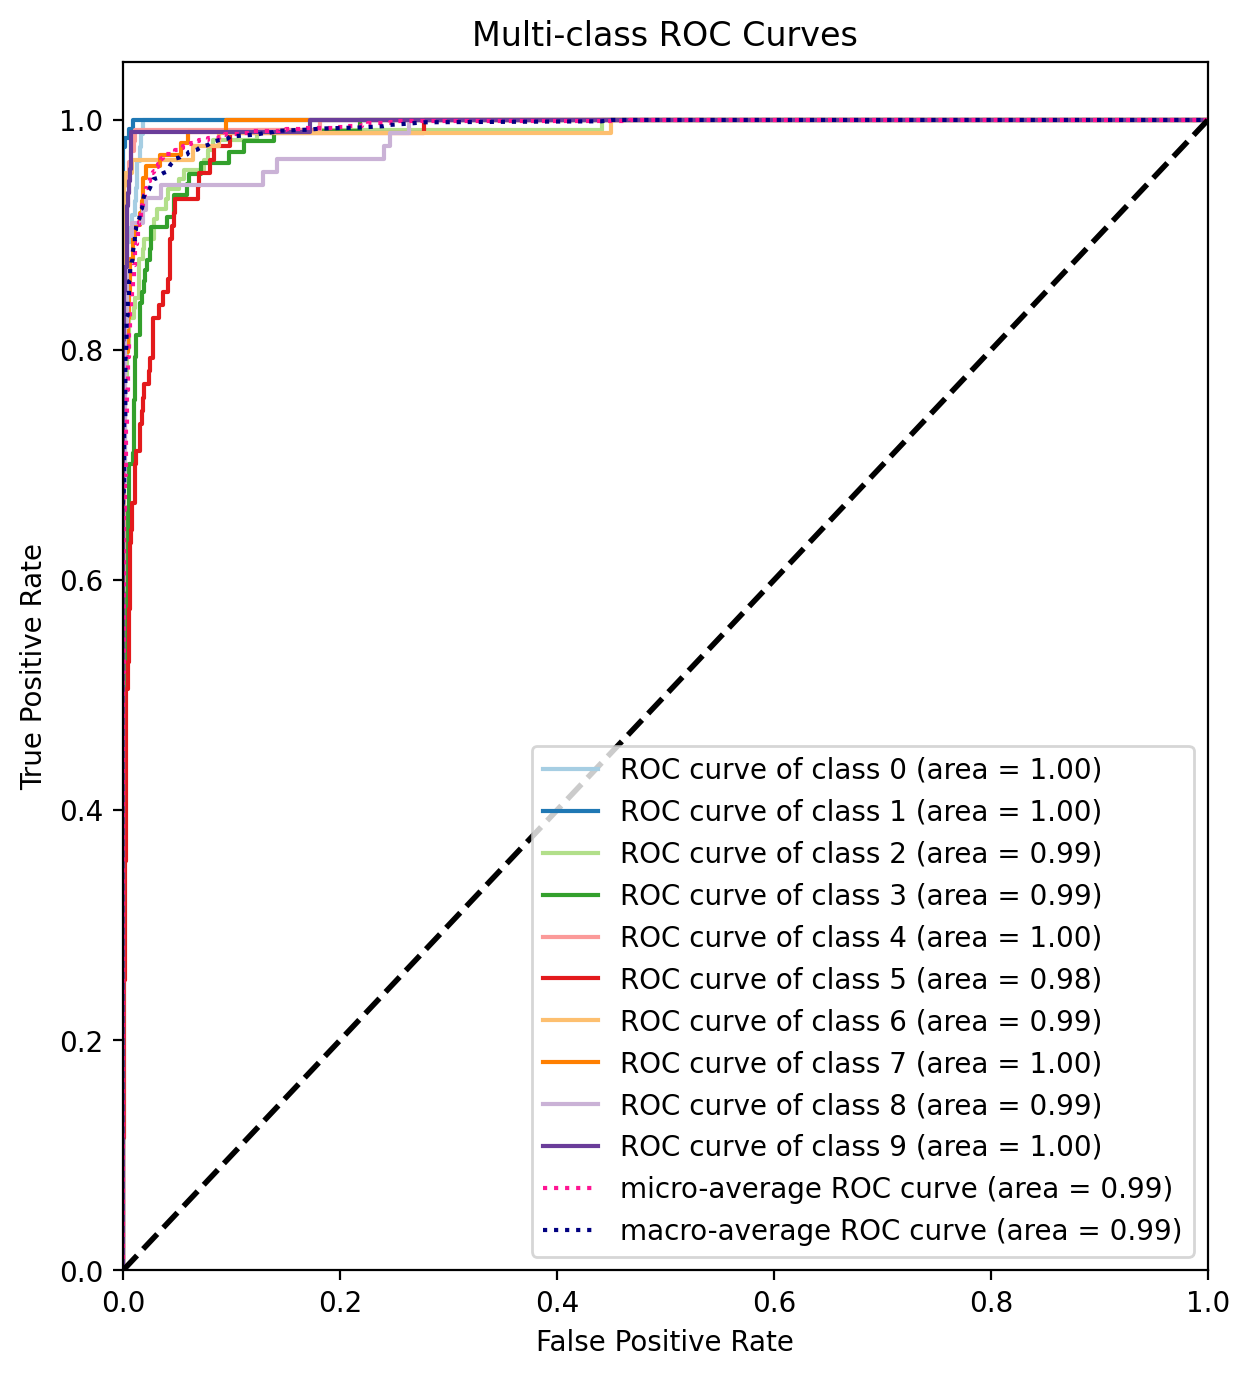

In [82]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Create the figure
roc_curve = plt.figure(figsize=(7, 8), dpi=200, facecolor='white')

# Plot ROC curve for each class
for i, color in zip(range(n_classes), COLORS):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

# Plot micro-average ROC curve
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
)

# Plot macro-average ROC curve
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
)

# Plot a 1:1 line
plt.plot([0, 1], [0, 1], "k--", lw=2)

# Set limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add labels, title and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curves")
plt.legend(loc="lower right")
plt.show()

Using the following cell, we zoom in on the top left of the figure for better visibility.

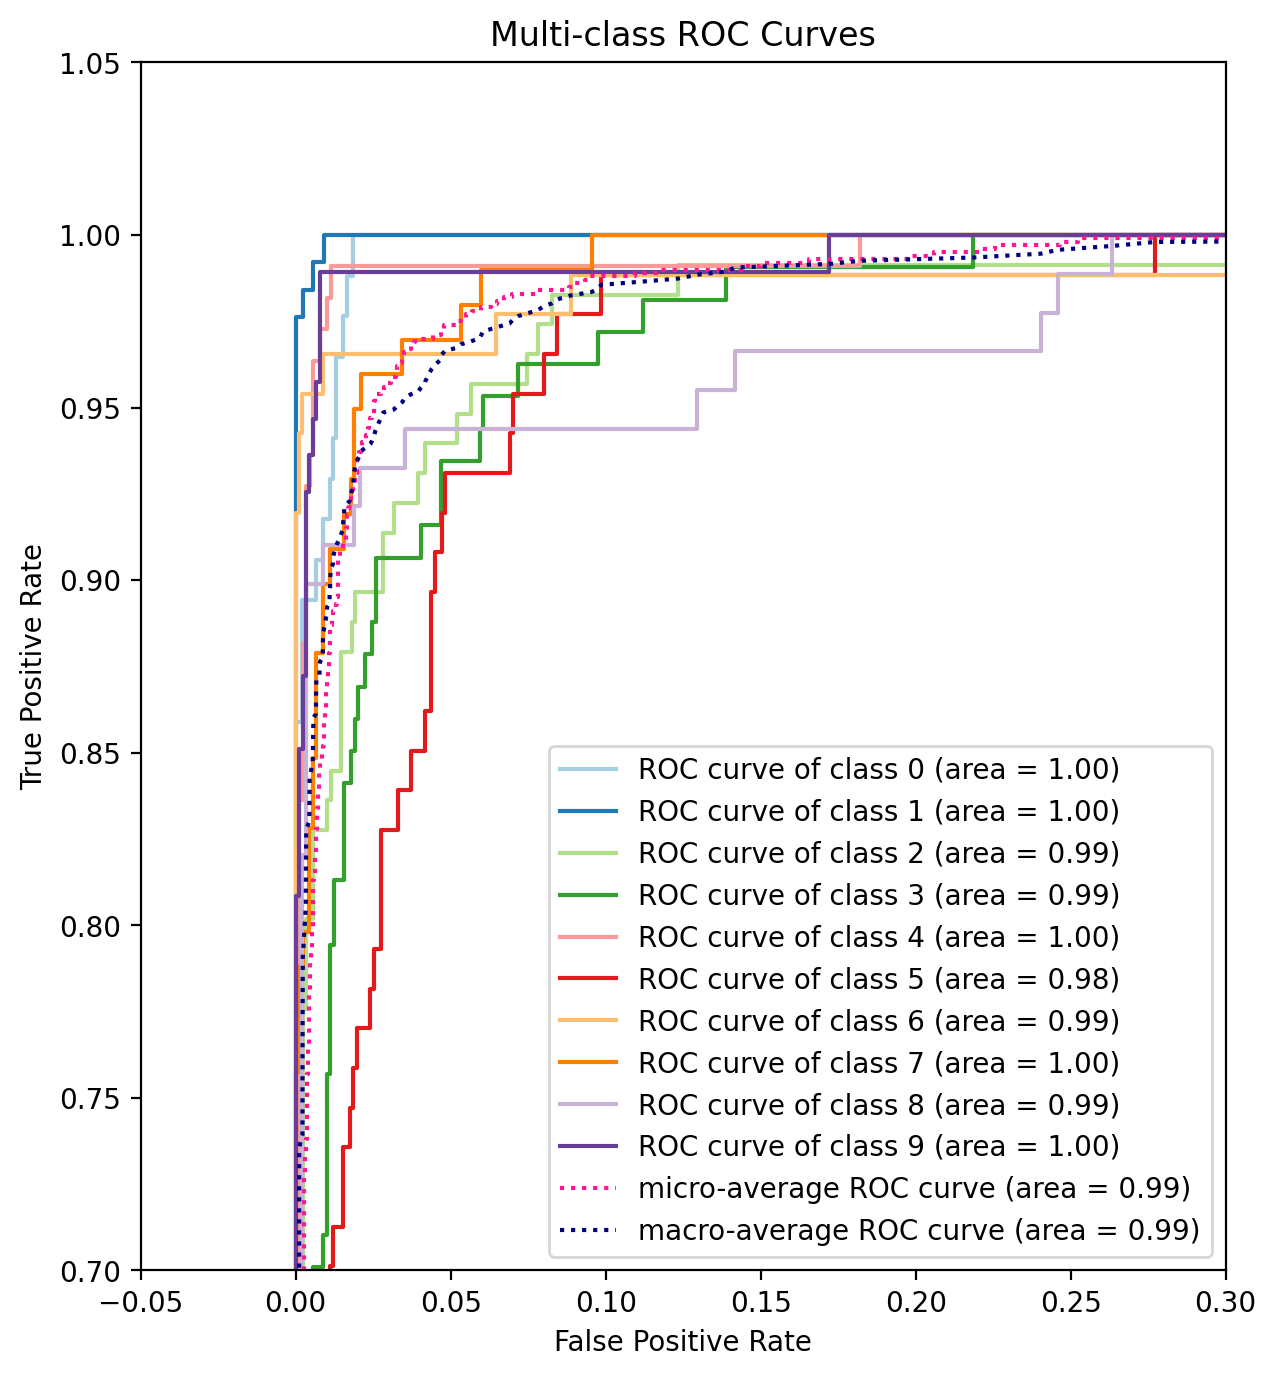

In [83]:
# Zoom in on the top left of the figure
ax = roc_curve.axes[0]
ax.set_xlim(-0.05, 0.3 )
ax.set_ylim(0.7, 1.05)
roc_curve

Typically in a good model, we expect that its AUC-ROC curve will be close to the top left corner like shown in the above example.
So in the above example, we can conclude that class 5 is the worst predicted and class 1 is predicted nicely.

**Precision Recall Curve:**\
The precision recall curve shows the trade-off between precision and recall for different thresholds.
A high area under the curve denotes both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.
A precision-recall curve is a plot of the precision (y-axis) and the recall (x-axis) for different thresholds, much like the ROC curve.
 
In the following snippet we calculate and display the precision and recall curve. It can be calculated using the `precision_recall_curve()` method that takes the true output values and the probabilities for the positive class as input, and returns the precision and recall values.
Similarly, we can calculate the average precision using the `average_precision_score()` method.
 
Then, by fattening our grid matrix we can compute the micro average of our Precision Recall curve.
Then we have plotted F1 lines of equal intervals between 0.2 to 0.8.
So we can see that each Precision Recall curve crosses these F1 lines.
 
Finally, using the special `PrecisionRecallDisplay()` method we can visualize our recall, precision, and average precision score.


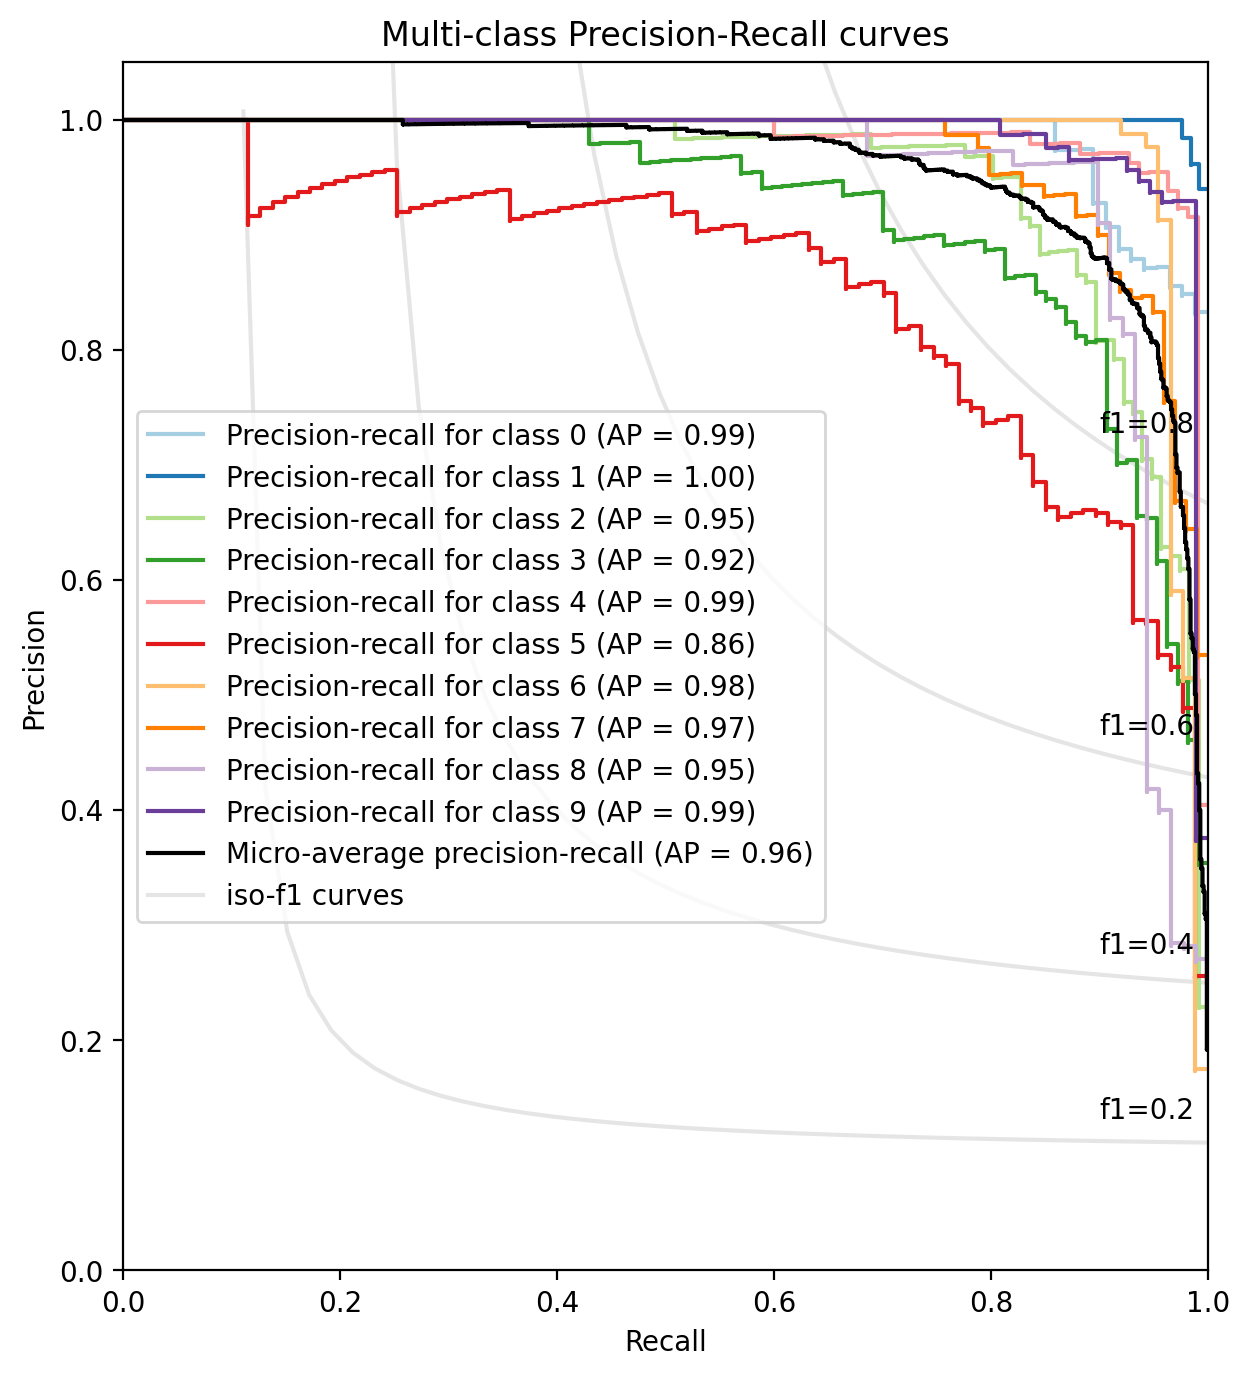

In [84]:
# Calculate precision, recall and average precision score for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

# Create figure and axis
_, ax = plt.subplots(figsize=(7, 8), dpi=200)

# Plot iso F1 lines
f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

# Plot the precision-recall curves for each of the classes
for i, color in zip(range(n_classes), COLORS):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# Plot the micro-averaged precision-recall curve
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="black")

# Add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])

# Set the legend, limits and title
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Multi-class Precision-Recall curves")
plt.show()


A good model will have its Precision Recall curve close to its top-right corner like in our sample output displayed in the image above.